### DS-GA 1011 Fall 2018 Assignment 2
#### RNN/CNN-based Natural Language Inference
Liangzhi Li

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(2018)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
cd /home/amberli/hw2/hi

/home/amberli/hw2/hi


In [3]:
assert torch.cuda.is_available and torch.has_cudnn

In [4]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

### read train and validation data

In [5]:
import csv
def readtsvfile(filename):
    texts = []
    with open(filename) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            texts.append(row)
    return texts

In [6]:
train_data_tokens = readtsvfile('snli_train.tsv')
val_data_tokens = readtsvfile('snli_val.tsv')
train_data_tokens = train_data_tokens[1::]
val_data_tokens = val_data_tokens[1::]
print('train data: {}'.format(len(train_data_tokens)))
print('validation data: {}'.format(len(val_data_tokens)))

train data: 100000
validation data: 1000


### load pretrained word embeddings from fastText

In [7]:
ft_home = './'
words_to_load = 50000

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    loaded_embeddings_ft[1,:]=np.random.randn(300)*0.01
    words_ft = {'<pad>':0,'<unk>':1}
    idx2words_ft = {0:'<pad>',1:'<unk>'}
    ordered_words_ft = ['<pad>','<unk>']
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])

tokenize sentence 1 and sentence 2

In [8]:
def tokenize(data):
    for i in range(len(data)):
        data[i][0]=data[i][0].split()
        data[i][1]=data[i][1].split()

In [9]:
tokenize(train_data_tokens)
tokenize(val_data_tokens)

In [10]:
label_dic = {'contradiction':1,'entailment':0,'neutral':2}
def token2id(data):
    data_id = []
    for i in range(len(data)):
        sent_id_1 = []
        for word in data[i][0]:
            if word in words_ft:
                sent_id_1.append(words_ft[word])
            else:
                word = '<unk>'
                sent_id_1.append(words_ft[word])
        sent_id_2 = []
        for word in data[i][1]:
            if word in words_ft:
                sent_id_2.append(words_ft[word])
            else:
                word = '<unk>'
                sent_id_2.append(words_ft[word])
        data[i][2] = label_dic[data[i][2]]        
        data_id.append([sent_id_1,sent_id_2,data[i][2]])
    return data_id

In [11]:
train_id = token2id(train_data_tokens)
val_id = token2id(val_data_tokens)

In [24]:
len1 = []
len2 = []
for i in range(1000):
    len1.append(len(train_data_tokens[i][0]))
    len2.append(len(train_data_tokens[i][1]))
print(max(len1))
print(max(len2))

72
27


In [12]:
## transform to dataloader

MAX_SENTENCE_LENGTH = 40

import numpy as np
import torch
from torch.utils.data import Dataset

class myDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_tuple):
        """
        @param data_list: list of my tokens 
        @param target_list: list of my targets 

        """
        #data_list1, data_list2, target_list
        self.data_list1, self.data_list2, self.target_list = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, token_idx2, len(token_idx1),len(token_idx2), label]

def my_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
    #ind_dec_order_1 = np.argsort(length_list1)[::-1]
    #ind_dec_order_2 = np.argsort(length_list2)[::-1]
    #data_list1 = np.array(data_list1)[ind_dec_order_1]
    #length_list1 = np.array(length_list1)[ind_dec_order_1]

    #data_list2 = np.array(data_list2)[ind_dec_order_2]
    #length_list2 = np.array(length_list2)[ind_dec_order_2]
    #label_list = np.array(label_list)[ind_dec_order]
    
    # keep track of original order:
    #ind_order_1 = np.argsort(ind_dec_order_1)
    #ind_order_2 = np.argsort(ind_dec_order_2)
    
    return [torch.from_numpy(np.array(data_list1)).to(device),torch.from_numpy(np.array(data_list2)).to(device), 
            torch.LongTensor(length_list1).to(device), 
            torch.LongTensor(length_list2).to(device), torch.LongTensor(label_list).to(device)]

# create pytorch dataloader
#train_loader = myDataset(train_data_indices, train_targets)
#val_loader = myDataset(val_data_indices, val_targets)
#test_loader = myDataset(test_data_indices, test_targets)

BATCH_SIZE = 32

train_dataset = myDataset(train_id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

val_dataset = myDataset(val_id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

## CNN

In [115]:
# CNN
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,kernel_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft))  #nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)
        #self.maxpool = nn.MaxPool1d(kernel_size = 3, padding=1)
        self.maxpool = nn.MaxPool1d(MAX_SENTENCE_LENGTH-kernel_size+1)
        self.linear1 = nn.Linear(2*hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x1, x2, lengths1, lengths2):
        batch_size, seq_len = x1.size()

        embed_1 = self.embedding(x1).float()
        embed_2 = self.embedding(x2).float()
        
        hidden_1 = self.conv1(embed_1.transpose(1,2)).transpose(1,2)
        #hidden_1 = F.relu(hidden_1)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len, hidden_1.size(-1))
        #hidden_1 = self.maxpool(hidden_1).view(batch_size,hidden_1.size(-1))
        
        hidden_1 = self.conv2(hidden_1.transpose(1,2)).transpose(1,2)
        #hidden_1 = F.relu(hidden_1)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, seq_len, hidden_1.size(-1))
        #hidden_1 = self.maxpool(hidden_1).view(batch_size,hidden_1.size(-1))
        hidden_1 = torch.max(hidden_1,dim=1)[0]

        #hidden_1 = torch.sum(hidden_1, dim=1)

        hidden_2 = self.conv1(embed_2.transpose(1,2)).transpose(1,2)
        #hidden_2 = F.relu(hidden_2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len, hidden_2.size(-1))
        #hidden_2 = self.maxpool(hidden_2).view(batch_size,hidden_2.size(-1))
        hidden_2 = self.conv2(hidden_2.transpose(1,2)).transpose(1,2)
        #hidden_2 = F.relu(hidden_2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, seq_len, hidden_2.size(-1))
        #hidden_2 = self.maxpool(hidden_2).view(batch_size,hidden_2.size(-1))
        hidden_2 = torch.max(hidden_2,dim=1)[0]
        
        #hidden_2 = torch.sum(hidden_2, dim=1)
        
        ## concat:
        hidden = torch.cat((hidden_1, hidden_2), 1)
        
        ## element-wise multiplication
        #hidden = hidden_1 * hidden_2


        logits = self.linear1(hidden)
        logits = torch.tanh(logits)
        logits = self.linear2(logits)
        
        return logits

In [116]:
from tqdm import tqdm_notebook

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1,data2, lengths1,lengths2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch1,lengths_batch2, label_batch= data1,data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch_1,data_batch_2, lengths_batch1,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=50000,kernel_size=3)
model.cuda()

learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
Train_Acc = []
Val_Acc = []
for epoch in range(num_epochs):
    train_loss = 0
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1,data2, lengths1, lengths2)
        loss = criterion(outputs, labels)
        train_loss += loss.data[0]

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 1000 iterations
        if i > 0 and i % 1000 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            Train_Acc.append(train_acc)
            Val_Acc.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}, loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc,  train_loss / len(train_loader)))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/10], Step: [1001/3125], Validation Acc: 62.1, Train Acc: 62.079, loss: 0.29427653551101685
Epoch: [1/10], Step: [2001/3125], Validation Acc: 64.3, Train Acc: 64.389, loss: 0.5650834441184998
Epoch: [1/10], Step: [3001/3125], Validation Acc: 64.8, Train Acc: 65.679, loss: 0.8290256857872009
Epoch: [2/10], Step: [1001/3125], Validation Acc: 63.4, Train Acc: 67.147, loss: 0.25121408700942993
Epoch: [2/10], Step: [2001/3125], Validation Acc: 64.9, Train Acc: 68.271, loss: 0.5005056262016296
Epoch: [2/10], Step: [3001/3125], Validation Acc: 64.5, Train Acc: 69.121, loss: 0.7474497556686401
Epoch: [3/10], Step: [1001/3125], Validation Acc: 66.2, Train Acc: 70.414, loss: 0.23049212992191315
Epoch: [3/10], Step: [2001/3125], Validation Acc: 65.2, Train Acc: 71.131, loss: 0.46164774894714355
Epoch: [3/10], Step: [3001/3125], Validation Acc: 66.5, Train Acc: 72.998, loss: 0.6938256025314331
Epoch: [4/10], Step: [1001/3125], Validation Acc: 66.0, Train Acc: 73.766, loss: 0.2125099003314

In [50]:
max(Val_Acc)

68.4

In [136]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1,data2, lengths1,lengths2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch1,lengths_batch2, label_batch= data1,data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch_1,data_batch_2, lengths_batch1,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(emb_size=300, hidden_size=50, num_layers=2, num_classes=3, vocab_size=50000,kernel_size=3)
model.cuda()

learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1,data2, lengths1, lengths2)
        loss = criterion(outputs, labels)
        train_loss += loss.data[0]

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 1000 iterations
        if i > 0 and i % 1000 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/10], Step: [1001/3125], Validation Acc: 58.6
Epoch: [1/10], Step: [2001/3125], Validation Acc: 62.3
Epoch: [1/10], Step: [3001/3125], Validation Acc: 62.8
Epoch: [2/10], Step: [1001/3125], Validation Acc: 60.5
Epoch: [2/10], Step: [2001/3125], Validation Acc: 61.8
Epoch: [2/10], Step: [3001/3125], Validation Acc: 63.2
Epoch: [3/10], Step: [1001/3125], Validation Acc: 62.6
Epoch: [3/10], Step: [2001/3125], Validation Acc: 64.1
Epoch: [3/10], Step: [3001/3125], Validation Acc: 65.1
Epoch: [4/10], Step: [1001/3125], Validation Acc: 65.1
Epoch: [4/10], Step: [2001/3125], Validation Acc: 66.7
Epoch: [4/10], Step: [3001/3125], Validation Acc: 65.3
Epoch: [5/10], Step: [1001/3125], Validation Acc: 64.9
Epoch: [5/10], Step: [2001/3125], Validation Acc: 65.8
Epoch: [5/10], Step: [3001/3125], Validation Acc: 66.1
Epoch: [6/10], Step: [1001/3125], Validation Acc: 66.7
Epoch: [6/10], Step: [2001/3125], Validation Acc: 65.7
Epoch: [6/10], Step: [3001/3125], Validation Acc: 67.4
Epoch: [7/

## RNN

In [ ]:
## RNN *** bidirectional, gru, with 2 fully connected layers
PAD_IDX = 0
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size # embed into continuous vector
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft))#.cuda()
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        hidden = hidden.cuda()

        return hidden

    def forward(self, x1, x2, lengths1,lengths2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        hidden_1 = self.init_hidden(batch_size)
        hidden_2 = self.init_hidden(batch_size)

        ## sort x1, x2 in descending order
        _, ind1 = torch.sort(lengths1, dim=0, descending=True)
        _, ind2 = torch.sort(lengths2, dim=0, descending=True)
        _, unind1 = torch.sort(ind1, dim=0)
        _, unind2 = torch.sort(ind2, dim=0)
        x1 = x1.index_select(0,ind1)
        x2 = x2.index_select(0,ind2)
        lengths1 = lengths1.index_select(0,ind1)
        lengths2 = lengths2.index_select(0,ind2)
        
        #print(type(x1))
        # get embedding of characters
        embed_1 = self.embedding(x1).float()
        
        embed_2 = self.embedding(x2).float()

        # pack padded sequence
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, lengths1.cpu().numpy(), batch_first=True)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, lengths2.cpu().numpy(), batch_first=True)

        _, hidden_1 = self.gru(embed_1, hidden_1)
        _, hidden_2 = self.gru(embed_2, hidden_2)


        hidden_1 = hidden_1.index_select(1,unind1)
        #print(hidden_1.shape)
        hidden_2 = hidden_2.index_select(1,unind2)
        
        
        hidden_1 = torch.max(hidden_1, dim=0)[0]
        #print(hidden_1.shape)
        hidden_2 = torch.max(hidden_2, dim=0)[0]
        
        
        ## concat:
        #hidden = torch.cat((hidden_1, hidden_2), 1)
        
        ## element wise multiplication:
        hidden = hidden_1 * hidden_2

        logits = self.linear1(hidden)
        logits = torch.tanh(logits)
        logits = self.linear2(logits)        


        return logits


In [111]:
import time

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1,data2, lengths1,lengths2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch1,lengths_batch2, label_batch = data1,data2, lengths1, lengths2, labels 
        outputs = F.softmax(model(data_batch_1,data_batch_2, lengths_batch1,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = RNN(emb_size=300, hidden_size=100, num_layers=2, num_classes=3, vocab_size=50000)
model.cuda()

learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
Train_Acc = []
Val_Acc = []
print('start:\n')
print(time.clock() / 60)
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1,data2, lengths1, lengths2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 1000 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            Train_Acc.append(train_acc)
            Val_Acc.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}, loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc,  loss))

print('end')
print(time.clock() / 60)

start:

483.42864085
Epoch: [1/10], Step: [1001/3125], Validation Acc: 54.8, Train Acc: 55.716, loss: 0.8937720060348511
Epoch: [1/10], Step: [2001/3125], Validation Acc: 59.6, Train Acc: 59.627, loss: 0.7011268734931946
Epoch: [1/10], Step: [3001/3125], Validation Acc: 60.3, Train Acc: 63.164, loss: 0.7405701875686646
Epoch: [2/10], Step: [1001/3125], Validation Acc: 64.7, Train Acc: 66.009, loss: 0.7355993390083313
Epoch: [2/10], Step: [2001/3125], Validation Acc: 69.0, Train Acc: 68.21, loss: 0.7544618248939514
Epoch: [2/10], Step: [3001/3125], Validation Acc: 68.5, Train Acc: 68.758, loss: 0.5797196626663208
Epoch: [3/10], Step: [1001/3125], Validation Acc: 67.9, Train Acc: 70.058, loss: 0.8906170129776001
Epoch: [3/10], Step: [2001/3125], Validation Acc: 66.5, Train Acc: 70.626, loss: 0.8185067772865295
Epoch: [3/10], Step: [3001/3125], Validation Acc: 69.9, Train Acc: 71.966, loss: 0.5813447833061218
Epoch: [4/10], Step: [1001/3125], Validation Acc: 67.4, Train Acc: 72.873, loss:

In [139]:
import time

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1,data2, lengths1,lengths2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch1,lengths_batch2, label_batch = data1,data2, lengths1, lengths2, labels 
        outputs = F.softmax(model(data_batch_1,data_batch_2, lengths_batch1,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model_rnn = RNN(emb_size=300, hidden_size=100, num_layers=1, num_classes=3, vocab_size=50000)
model_rnn.cuda()

learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
print('start:\n')
print(time.clock() / 60)
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model_rnn.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model_rnn(data1,data2, lengths1, lengths2)
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 1000 == 0:
            # validate
            val_acc = test_model(val_loader, model_rnn)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

print('end')
print(time.clock() / 60)

start:

602.05972495
Epoch: [1/10], Step: [1001/3125], Validation Acc: 55.5
Epoch: [1/10], Step: [2001/3125], Validation Acc: 61.9
Epoch: [1/10], Step: [3001/3125], Validation Acc: 66.1
Epoch: [2/10], Step: [1001/3125], Validation Acc: 65.4
Epoch: [2/10], Step: [2001/3125], Validation Acc: 68.4
Epoch: [2/10], Step: [3001/3125], Validation Acc: 68.1
Epoch: [3/10], Step: [1001/3125], Validation Acc: 68.1
Epoch: [3/10], Step: [2001/3125], Validation Acc: 68.3
Epoch: [3/10], Step: [3001/3125], Validation Acc: 70.6
Epoch: [4/10], Step: [1001/3125], Validation Acc: 68.4
Epoch: [4/10], Step: [2001/3125], Validation Acc: 71.9
Epoch: [4/10], Step: [3001/3125], Validation Acc: 71.2
Epoch: [5/10], Step: [1001/3125], Validation Acc: 70.5
Epoch: [5/10], Step: [2001/3125], Validation Acc: 70.8
Epoch: [5/10], Step: [3001/3125], Validation Acc: 72.6
Epoch: [6/10], Step: [1001/3125], Validation Acc: 69.6
Epoch: [6/10], Step: [2001/3125], Validation Acc: 72.7
Epoch: [6/10], Step: [3001/3125], Validation

In [112]:
rnn_train_acc_mul_100 = Train_Acc
rnn_val_acc_mul_100 = Val_Acc

In [117]:
cnn_train_acc_concat_200 = Train_Acc
cnn_val_acc_concat_200 = Val_Acc

In [118]:
import csv

res = [cnn_train_acc_concat_200, cnn_val_acc_concat_200]
csvfile = '/home/jupyter/cnn_concat_200.csv'
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(res)

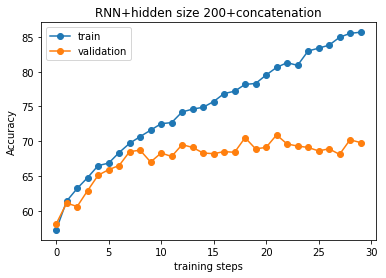

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rnn_train_acc_concat_200,'-o')
#plt.legend(['validation'])
plt.plot(rnn_val_acc_concat_200,'-o')
plt.xlabel('training steps')
plt.ylabel('Accuracy')
plt.legend(('train','validation'))
plt.title('RNN+hidden size 200+concatenation')

plt.savefig('/home/jupyter/rnn_acc_concat_200.png')

In [37]:
import pandas as pd

In [43]:
rnn_acc_concat_200 = pd.read_csv('/home/jupyter/rnn_concat_200.csv',header = None)
rnn_acc_concat_200.T[0].plot()

In [81]:
print(max(cnn_val_acc_concat_10))
print(max(cnn_val_acc_concat_20))
print(max(cnn_val_acc_concat_50))
print(max(cnn_val_acc_concat_100))
print(max(cnn_val_acc_concat_500))

64.7
66.2
68.9
67.2
66.8


In [109]:
print(max(rnn_val_acc_concat_10))
print(max(rnn_val_acc_concat_20))
print(max(rnn_val_acc_concat_50))
print(max(rnn_val_acc_concat_100))
print(max(rnn_val_acc_concat_200))
print(max(rnn_val_acc_concat_500))

65.1
68.3
70.6
70.0
70.9
70.8


## MultiNLI

Imort MNLI dataset

In [123]:
#train = pd.read_table('mnli_train.tsv')
val = pd.read_table('mnli_val.tsv')

#fiction_train = train.loc[train['genre']=='fiction'][['sentence1','sentence2','label']].values.tolist()
#telephone_train = train.loc[train['genre']=='telephone'][['sentence1','sentence2','label']].values.tolist()
#slate_train = train.loc[train['genre']=='slate'][['sentence1','sentence2','label']].values.tolist()
#government_train = train.loc[train['genre']=='government'][['sentence1','sentence2','label']].values.tolist()
#travel_train = train.loc[train['genre']=='travel'][['sentence1','sentence2','label']].values.tolist()

fiction_val = val.loc[val['genre']=='fiction'][['sentence1','sentence2','label']].values.tolist()
telephone_val = val.loc[val['genre']=='telephone'][['sentence1','sentence2','label']].values.tolist()
slate_val = val.loc[val['genre']=='slate'][['sentence1','sentence2','label']].values.tolist()
government_val = val.loc[val['genre']=='government'][['sentence1','sentence2','label']].values.tolist()
travel_val = val.loc[val['genre']=='travel'][['sentence1','sentence2','label']].values.tolist()

Tokenization

In [124]:
#tokenize(fiction_train)
tokenize(fiction_val)

#tokenize(telephone_train)
tokenize(telephone_val)

#tokenize(slate_train)
tokenize(slate_val)

#tokenize(government_train)
tokenize(government_val)

#tokenize(travel_train)
tokenize(travel_val)

In [126]:
#fiction_train_id = token2id(fiction_train)
fiction_val_id = token2id(fiction_val)

#telephone_train_id = token2id(telephone_train)
telephone_val_id = token2id(telephone_val)

#slate_train_id = token2id(slate_train)
slate_val_id = token2id(slate_val)

#government_train_id = token2id(government_train)
government_val_id = token2id(government_val)

#travel_train_id = token2id(travel_train)
travel_val_id = token2id(travel_val)

In [134]:
fiction_val_dataset = myDataset(fiction_val_id)
fiction_val_loader = torch.utils.data.DataLoader(dataset=fiction_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

telephone_val_dataset = myDataset(telephone_val_id)
telephone_val_loader = torch.utils.data.DataLoader(dataset=telephone_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

slate_val_dataset = myDataset(slate_val_id)
slate_val_loader = torch.utils.data.DataLoader(dataset=slate_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

government_val_dataset = myDataset(government_val_id)
government_val_loader = torch.utils.data.DataLoader(dataset=government_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)

travel_val_dataset = myDataset(travel_val_id)
travel_val_loader = torch.utils.data.DataLoader(dataset=travel_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=my_collate_func,
                                           shuffle=True)


In [137]:
print('CNN')
print('Validation Accuracy for fiction: {}'.format(test_model(fiction_val_loader, model)))
print('Validation Accuracy for telephone: {}'.format(test_model(telephone_val_loader, model)))
print('Validation Accuracy for slate: {}'.format(test_model(slate_val_loader, model)))
print('Validation Accuracy for government: {}'.format(test_model(government_val_loader, model)))
print('Validation Accuracy for travel: {}'.format(test_model(travel_val_loader, model)))

CNN
Validation Accuracy for fiction: 44.824120603015075
Validation Accuracy for telephone: 45.97014925373134
Validation Accuracy for slate: 42.71457085828343
Validation Accuracy for government: 43.30708661417323
Validation Accuracy for travel: 45.11201629327902


In [135]:
print('RNN')
print('Validation Accuracy for fiction: {}'.format(test_model(fiction_val_loader, model)))
print('Validation Accuracy for telephone: {}'.format(test_model(telephone_val_loader, model)))
print('Validation Accuracy for slate: {}'.format(test_model(slate_val_loader, model)))
print('Validation Accuracy for government: {}'.format(test_model(government_val_loader, model)))
print('Validation Accuracy for travel: {}'.format(test_model(travel_val_loader, model)))

RNN
Validation Accuracy for fiction: 44.321608040201006
Validation Accuracy for telephone: 40.69651741293532
Validation Accuracy for slate: 41.91616766467066
Validation Accuracy for government: 46.06299212598425
Validation Accuracy for travel: 43.17718940936864


Get examples

In [140]:
def test_model_2(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    i=0
    pred = []
    label = []
    DATA1 = []
    DATA2 = []
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data_batch_1,data_batch_2, lengths_batch1,lengths_batch2, label_batch = data1,data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch_1,data_batch_2, lengths_batch1,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        pred.append(predicted.view_as(labels))
        DATA1.append(data1)
        DATA2.append(data2)
        label.append(labels)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return DATA1, DATA2, pred, label

In [141]:
DATA1, DATA2, pred, label = test_model_2(val_loader,model_rnn)

In [206]:
i=20
print('label: {}'.format(label[i]))
print('prediction: {}'.format(pred[i]))
print('equal: {}'.format(label[i] == pred[i]))

label: tensor([1, 2, 1, 0, 2, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0,
        1, 1, 1, 2, 2, 1, 1, 1], device='cuda:0')
prediction: tensor([2, 1, 1, 0, 2, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 0, 1, 2,
        1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
equal: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)


In [210]:
j=0
example1 = DATA1[i][j]
example1 = example1.tolist()
example1 = list(filter(lambda a: a != 0, example1))
example1_text = []
for m in range(len(example1)):
    example1_text.append(idx2words_ft[example1[m]])
    
example2 = DATA2[i][j]
example2 = example2.tolist()
example2 = list(filter(lambda a: a != 0, example2))
example2_text = []
for k in range(len(example2)):
    example2_text.append(idx2words_ft[example2[k]])    

    
print(' '.join(example1_text))
print(' '.join(example2_text))
print('true label: {}'.format(list(label_dic.keys())[list(label_dic.values()).index(label[i][j])]))
print('predicted label: {}'.format(list(label_dic.keys())[list(label_dic.values()).index(pred[i][j])]))

a surfer is riding the waves whilst another surfer sits on his board waiting .
A surfer watches as his friend is eaten by a large shark .
true label: contradiction
predicted label: neutral


In [188]:
k=1
pred[i][k]

tensor(0, device='cuda:0')